In [293]:
from emd_analysis_functions import *

In [494]:
# signal generation initialisation
srate = 1000
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 25, 24*10, 'linear')

# Generated signals
data_length=30 #time in seconds",
npnts = srate*data_length #number of points to generate,
t  = np.arange(0,npnts)/srate #time vector
nonmodulatedamplitude=2; # increase this to get less modulation (lower MI value),
Phase_Modulating_Freq=8
Amp_Modulated_Freq=80
# fp is the theta/phase frequency
# fa is the gamma/amplitude frequency                         X
A_fa=(0.2*(np.sin(2*np.pi*t*Phase_Modulating_Freq)+1)+nonmodulatedamplitude*0.1)
A_fpmax = 1 #Maximal amplitude of fp
theta_pure = A_fpmax*np.sin(2*np.pi*t*Phase_Modulating_Freq)
gamma_pure = np.sin(2*np.pi*t*Amp_Modulated_Freq)


# for the influence of noise
# construct a fixed theta wave, iterated sine of the 8th order 
fixed_theta_noise = iterated_sine(theta_pure, 8)
generated_lfps_noise = []
# we will add noise with 20 different types of sigma
noise_bins = np.linspace(0.1, 2, 20)
# this is the component that modulates the pure gamma wave, is based on the theta wave present of course
A_fa_noise = (0.2*(fixed_theta_noise+1)+nonmodulatedamplitude*0.1)
# the whole gamma component will be the pure gamme with 
fixed_gamma_noise = A_fa_noise * gamma_pure

theta_fourhz = iterated_sine( A_fpmax*np.sin(2*np.pi*t*4), 8)


In [773]:
# convert a signal to its phase-aligned waveform
def calc_pa_wf(signal, srate, npoints=48):
    IP, IF, _ = emd.spectra.frequency_transform(signal, srate, 'nht')
    pa_signal = emd.cycles.phase_align(IP, signal, npoints = npoints)
    return np.nanmean(pa_signal[0], axis=1)

def calc_pa_IF(signal, srate, amppercentile = 33, npoints=48):
    IP, IF, IA = emd.spectra.frequency_transform(signal, srate, 'nht')
    thresh = np.percentile(IA, amppercentile)
    mask = IA > thresh
    mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)
    pa_if_signal = emd.cycles.phase_align(IP, IF, cycles = mask_cycles, npoints=npoints)
    return np.nanmean(pa_if_signal[0], axis=1)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


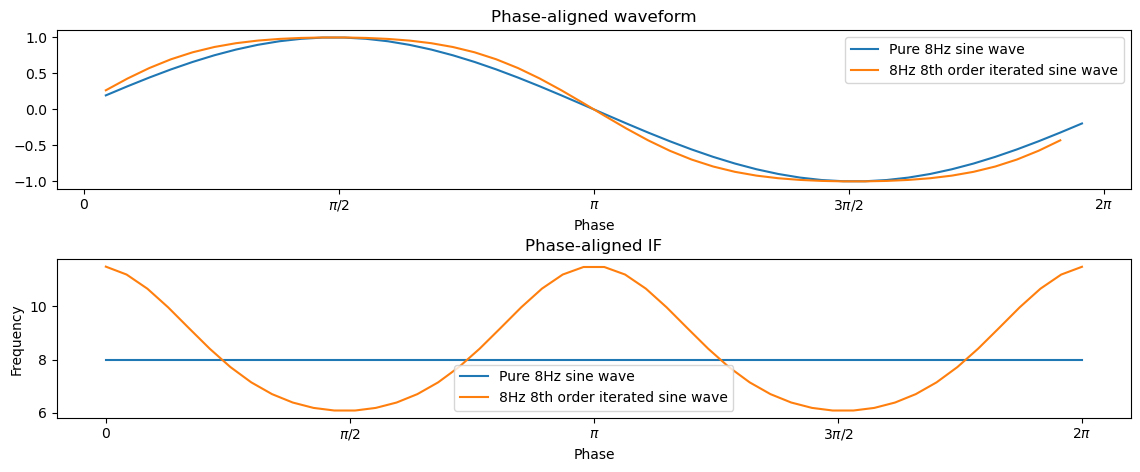

In [438]:
fig873, axs873 = plt.subplots(2,1, figsize=(12,5))
fig873.tight_layout(pad=3)
xaxis = np.linspace(0,2*np.pi, 48)
label_pure = 'Pure 8Hz sine wave'
label_itsin = '8Hz 8th order iterated sine wave'
axs873[0].plot(xaxis, calc_pa_wf(theta_pure, srate), label = label_pure)
axs873[0].plot(xaxis, calc_pa_wf(fixed_theta_noise, srate), label = label_itsin)
axs873[0].set_xticks([0,0.5*np.pi, np.pi, 3/2*np.pi, 2*np.pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs873[0].set_xlabel('Phase')
axs873[0].set_title('Phase-aligned waveform')
axs873[0].legend()
axs873[1].plot(xaxis, calc_pa_IF(theta_pure, srate), label = label_pure)
axs873[1].plot(xaxis, calc_pa_IF(fixed_theta_noise, srate), label = label_itsin)
axs873[1].set_xticks([0,0.5*np.pi, np.pi, 3/2*np.pi, 2*np.pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs873[1].set_xlabel('Phase')
axs873[1].set_title('Phase-aligned IF')
axs873[1].set_ylabel('Frequency')
axs873[1].legend()
plt.show()

In [300]:
# EMD sifting configurations
#Method #1: iterated mask default settings
itmaskconfig = emd.sift.get_config('iterated_mask_sift')
itmaskconfig['max_imfs'] = 8
itmaskconfig['sample_rate'] = srate
itmaskconfig['ret_mask_freq'] = True
itmask = partial(emd.sift.iterated_mask_sift, **itmaskconfig)
itmaskconfig['max_imfs'] = 6
itmask_gen = partial(emd.sift.iterated_mask_sift, **itmaskconfig)

# Method #2: mask sift with mask frequency based on amplitude-weighted mean IF of first IMF from regular sifting. 
ifmaskconfig = emd.sift.get_config('mask_sift')
ifmaskconfig['mask_freqs'] = 'if'
ifmaskconfig['max_imfs'] = 8
# To compare the masks used
ifmaskconfig['ret_mask_freq'] = True
# the function ifmask will run a masked sift on a signal x, with the mask frequency based on IF of first IMF.
# should return the IMFs and the mask frequencies used
ifmask = partial(emd.sift.mask_sift, **ifmaskconfig)
ifmaskconfig['max_imfs'] = 8
ifmask_gen = partial(emd.sift.mask_sift, **ifmaskconfig)

# Method #3: mask sift with mask frequency based on the amount of zero crossings of first IMF through 'regular' sifting. 
zcmaskconfig = emd.sift.get_config('mask_sift')
zcmaskconfig['max_imfs'] = 8
zcmaskconfig['ret_mask_freq'] = True
# the function zcmask will run a masked sift on a signal x, with the mask frequency based on the amount of zero crossings of first IMF.
# should return the IMFs and the mask frequencies used
zcmask = partial(emd.sift.mask_sift, **zcmaskconfig)
zcmaskconfig['max_imfs'] = 8
zcmask_gen = partial(emd.sift.mask_sift, **zcmaskconfig)

#Method #4: iterated mask IF
itmaskifconfig = emd.sift.get_config('iterated_mask_sift')
itmaskifconfig['max_imfs'] = 8
itmaskifconfig['sample_rate'] = srate
itmaskifconfig['ret_mask_freq'] = True
itmaskifconfig['mask_0'] = 'if'
itmaskif = partial(emd.sift.iterated_mask_sift, **itmaskifconfig)
itmaskifconfig['max_imfs'] = 6
itmaskif_gen = partial(emd.sift.iterated_mask_sift, **itmaskifconfig)

# Method #5: Ensemble sift with 24 ensembles
# imf4 = emd.sift.ensemble_sift(lfp, max_imfs=10, nensembles=24, nprocesses=6, ensemble_noise=1)
ensembleconfig = emd.sift.get_config('ensemble_sift')
ensembleconfig['nensembles'] = 24
ensembleconfig['max_imfs'] = 8
ensembleconfig['nprocesses'] = 6
ensembleconfig['ensemble_noise'] = 1
ensemble = partial(emd.sift.ensemble_sift, **ensembleconfig)
ensembleconfig['max_imfs'] = 6
ensemble_gen = partial(emd.sift.ensemble_sift, **ensembleconfig)


method_names = ['Iterated mask ZC EMD', 'Masked IF EMD', 'Masked ZC EMD', 'Iterated mask IF EMD', 'Ensemble EMD']
method_colors = ['blue', 'orange', 'green', 'red', 'purple']
method_dict = {'Iterated mask ZC EMD': 'blue', 'Masked IF EMD':'orange',  'Masked ZC EMD':'green', 'Iterated mask IF EMD':'red', 'Ensemble EMD':'purple'}


In [301]:
# list of EMD configs for the synthetic/generated signals
maskmethods_gen = [itmask_gen, ifmask_gen, zcmask_gen, itmaskif_gen]
ensemblemethods_gen = [ensemble_gen]

In [774]:
#TEST
corrs_test = np.zeros((len(noise_bins), len(method_names), 100))
fixed_theta_paIF = calc_pa_IF(fixed_theta_noise, srate)
for iteration in range(2):
    # create a set of 20 signals, with noise ranging from 0.1 to 2.
    for row, sigma in enumerate(noise_bins):
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        _, selected_imfs_all, _, _, _, _ = gensignal_analysis(lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        for col, imf in enumerate(selected_imfs_all):
            try:
                imf_pa_IF = calc_pa_IF(imf, srate)
                corr = scipy.stats.pearsonr(fixed_theta_paIF, imf_pa_IF)[0]
            except:
                corr = np.nan
            corrs_test[row,col,iteration] = corr
    print('\r i = {} , {}'.format(iteration, (corrs_test[:,:,iteration]) ), end="")


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inp

In [349]:
#THE FIRST 70 CORRS for increasing noise
selected_imfs_trials = []

corrs = np.zeros((len(noise_bins), len(method_names), 100))
fixed_theta_paIF = calc_pa_IF(fixed_theta_noise, srate)
for iteration in range(70):
    # create a set of 20 signals, with noise ranging from 0.1 to 2.
    for row, sigma in enumerate(noise_bins):
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        _, selected_imfs_all, _, _, _, _ = gensignal_analysis(lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        for col, imf in enumerate(selected_imfs_all):
            try:
                imf_pa_IF = calc_pa_IF(imf, srate)
                corr = scipy.stats.pearsonr(fixed_theta_paIF, imf_pa_IF)[0]
            except:
                corr = np.nan
            corrs[row,col,iteration] = corr
    print('\r i = {} , {}'.format(iteration, (corrs[:,:,iteration]) ), end="")


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inp

In [423]:
corrs_mean_noise_70 = np.nanmean(corrs[:,:,:70], axis=2)
corrs_std_noise_70 = np.nanstd(corrs[:,:,:70], axis=2)

In [600]:
sigmatest = [0.2,1,2]
selimf_allall = []
for sigma in sigmatest:
    lfpt = fixed_gamma_noise + fixed_theta_noise  
    gauss = sigma * np.random.randn(1,len(lfpt)) #gaussian noise
    lfpt= np.add(lfpt,gauss[0])
    _, selected_imfs_all, _, _, _, _ = gensignal_analysis(lfpt, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
    selimf_allall.append(selected_imfs_all)


In [626]:
IPgt, IFgt, IAgt = emd.spectra.frequency_transform(fixed_theta_noise, srate, 'nht')
cyclesgt = emd.cycles.get_cycle_vector(IPgt)
paifgt = emd.cycles.phase_align(IPgt, IFgt, cycles = cyclesgt)
avgpaifgt = np.mean(paifgt[0], axis=1)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inp

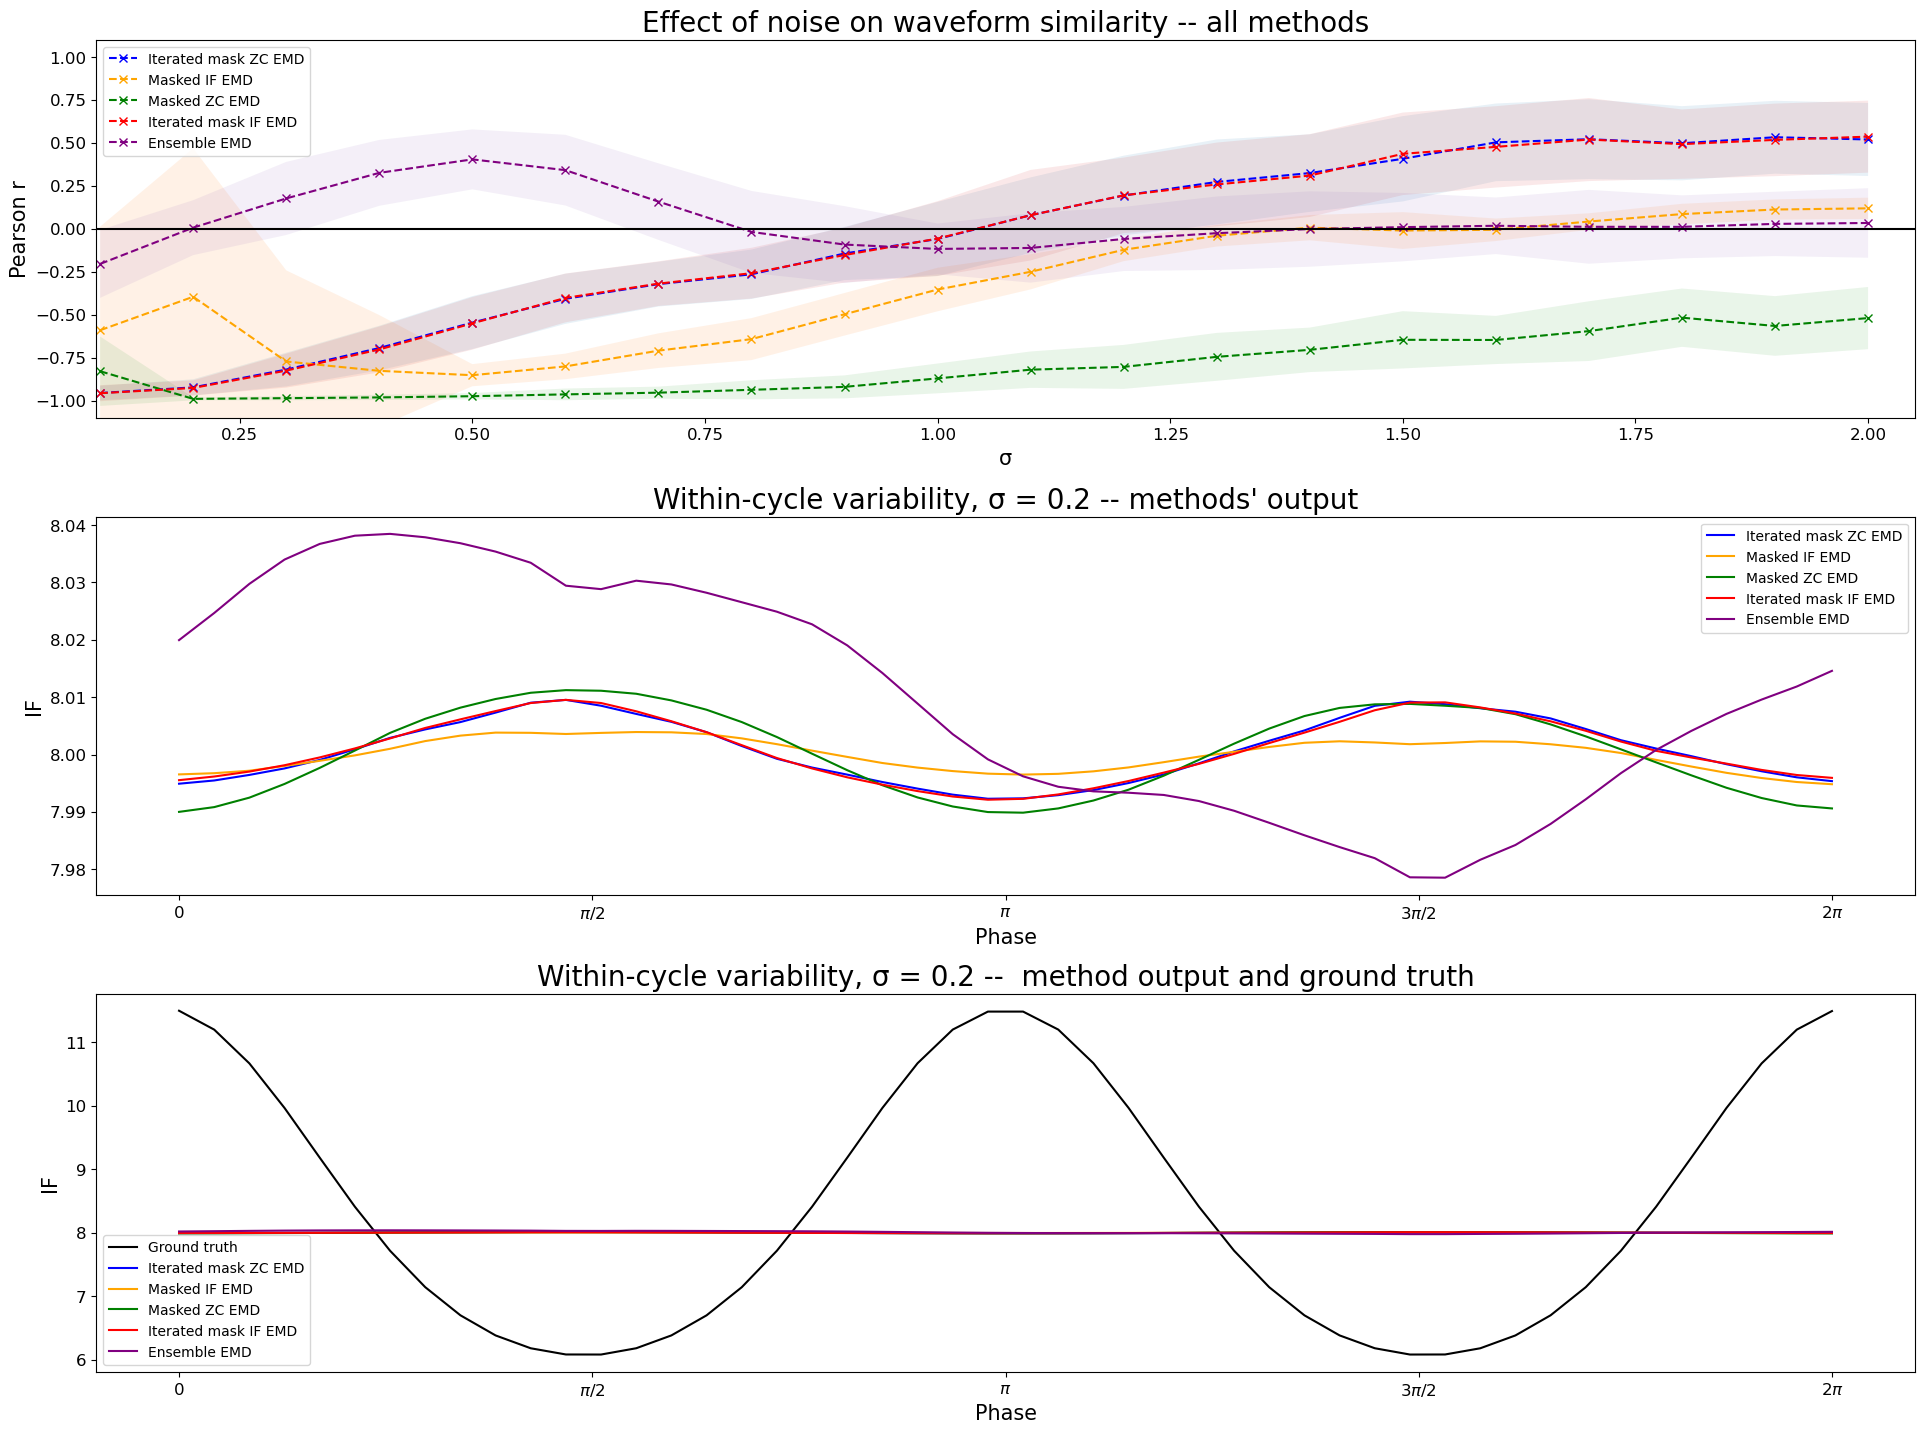

In [622]:
# increasing noise corrs plot (first 70)
fig1, axs1 = plt.subplots(3, 1, figsize=(20,15))
fig1.tight_layout(pad=5)
for method, errors, method_name, color in zip(corrs_mean_noise_70.T, corrs_std_noise_70.T, method_names, method_colors):
    axs1[0].plot(noise_bins, method, '--x', label = method_name, color=method_dict[method_name])
    axs1[0].fill_between(noise_bins, method-errors, method+errors, alpha=0.1)
    axs1[0].set_ylabel('Pearson r', size=15)
    axs1[0].set_xlabel('\u03C3', size=15)
    axs1[0].set_title('Effect of noise on waveform similarity -- all methods', size = 20)
    
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    axs1[0].set_xlim(0.096,2.05)
    axs1[0].set_ylim(-1.1,1.1)
    axs1[0].legend()
axs1[0].plot(np.zeros_like(method), color='black')
axs1[0].tick_params(axis='both', labelsize=12)
# for method, errors, method_name in zip(test_mean2.T, test_std2.T, method_names3):

for imf, method_name in zip(selimf_allall[0], method_names):
    axs1[1].plot(xaxis, calc_pa_IF(imf,srate), label = method_name, color = method_dict[method_name])
axs1[1].legend()
axs1[1].set_xticks([0,0.5*np.pi, np.pi, 3/2*np.pi, 2*np.pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'],size=12)
axs1[1].tick_params(axis='y', labelsize=12)
axs1[1].set_xlabel('Phase', size=15)
axs1[1].set_ylabel('IF', size=15)
axs1[1].set_title('Within-cycle variability, \u03C3 = 0.2 -- methods\' output', size=20)

axs1[2].plot(xaxis, avgpaifgt, color='black', label='Ground truth')
for imf, method_name in zip(selimf_allall[0], method_names):
    axs1[2].plot(xaxis, calc_pa_IF(imf,srate) , label = method_name, color = method_dict[method_name])
axs1[2].set_xticks([0,0.5*np.pi, np.pi, 3/2*np.pi, 2*np.pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], size=12)
axs1[2].tick_params(axis='y', labelsize=12)
axs1[2].set_xlabel('Phase', size=15)
axs1[2].set_ylabel('IF', size=15)
axs1[2].set_title('Within-cycle variability, \u03C3 = 0.2 --  method output and ground truth', size=20)
axs1[2].legend()
plt.show()

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

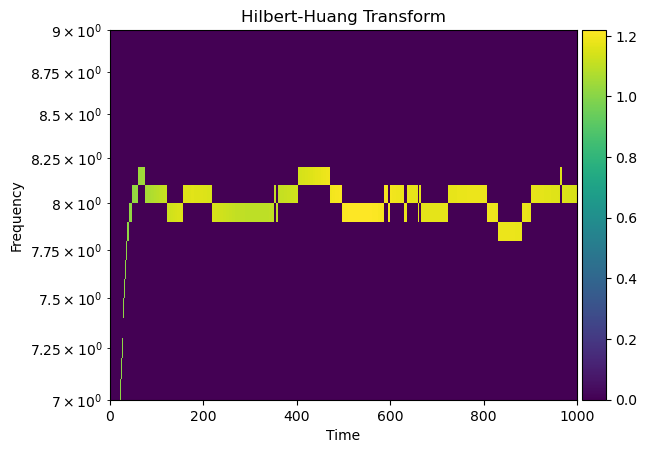

In [759]:
# testing on output of itemdzc
tester = selimf_allall[0][0]
time_centres = np.arange(len(tester))-.5
IPtest, IFtest, IAtest = emd.spectra.frequency_transform(tester, srate, 'nht')
f1, hht1 = emd.spectra.hilberthuang(IFtest, IAtest, freq_edges, mode='amplitude', sum_time=False)
emd.plotting.plot_hilberthuang(hht1, time_centres, f1,
                               cmap='viridis', time_lims = (0,srate), freq_lims=(7,9), log_y=True)

In [760]:
cycles_test = emd.cycles.get_cycle_vector(IPtest)
pa_if_test, _ = emd.cycles.phase_align(IPtest, IFtest, cycles = cycles_test)
# return np.nanmean(pa_if_signal[0], axis=1)
print(pa_if_test.shape)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'
(48, 238)


In [767]:
thresh = np.percentile(IAtest, 50)
mask = IAtest > thresh

mask_cycles = emd.cycles.get_cycle_vector(IPtest, return_good=True, mask=mask)

In [768]:
mask_cycles.shape

(30000, 1)

In [769]:
pa_if_test_mc, _ = emd.cycles.phase_align(IPtest, IFtest, cycles = mask_cycles)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


In [770]:
pa_if_test_mc.shape

(48, 58)

In [771]:
paif_mean_mc = np.mean(pa_if_test_mc,axis=1)
avg_pa_if_test = np.mean(pa_if_test, axis=1)

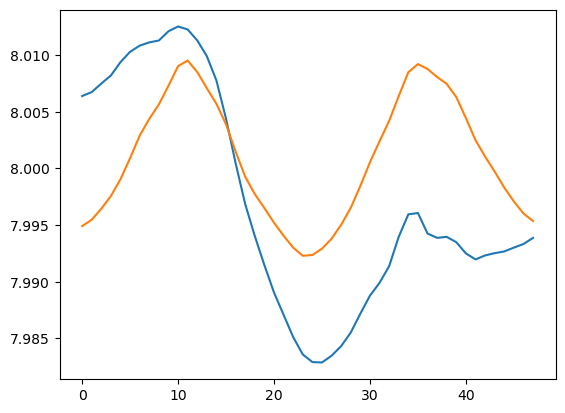

In [772]:
plt.plot(paif_mean_mc)
plt.plot(avg_pa_if_test)

In [730]:
paif_mean_mc

array([8.21662835, 8.23091553, 8.24430929, 8.25660919, 8.26984778,
       8.2831901 , 8.29455314, 8.30338212, 8.31064805, 8.3171904 ,
       8.32068015, 8.31995782, 8.32417681, 8.32659875, 8.32235742,
       8.3135209 , 8.30291804, 8.29038823, 8.27644209, 8.26143151,
       8.24594538, 8.22883436, 8.20835635, 8.18432207, 8.15716185,
       8.12692649, 8.09334843, 8.06066132, 8.02986142, 8.00298649,
       7.9806179 , 7.96211684, 7.9469866 , 7.93406516, 7.92133352,
       7.89931739, 7.87043488, 7.8515699 , 7.8399844 , 7.83636867,
       7.84012792, 7.84941015, 7.86663051, 7.89159369, 7.92064509,
       7.94780216, 7.97193672, 7.99275386])

In [715]:
twin = emd.cycles.get_cycle_stat(cycles_test, IFtest, mode='cycle')

 Checking get_cycle_stat inputs - trimming singleton from input 'values'
 Checking _check_cycle_inputs inputs - trimming singleton from input 'cycles'


In [716]:
twin.shape

(238,)

In [710]:
twin[1]

7.9819367453414705

In [709]:
avg_pa_if np.mean(pa_if_test, axis=1)

array([8.19811722, 8.00801506, 8.42640738, 7.94657266, 8.2169397 ,
       7.68534215, 8.07781358, 7.58131541, 8.58981707, 7.98299037,
       7.60588172, 8.72809786, 7.89074211, 7.65141441, 8.30451782,
       8.35097438, 7.78688007, 8.26661981, 7.84344441, 7.94610135,
       8.50635964, 7.66482349, 8.06203534, 8.07060928, 8.09976862,
       8.00779815, 8.03828455, 8.38151411, 7.84454619, 8.05243584,
       7.93902451, 7.95055861, 8.31294045, 8.08678198, 8.07023912,
       7.81728996, 8.21299544, 8.11764415, 7.70771403, 8.20718617,
       8.30464086, 7.90382357, 8.41517091, 7.45300139, 8.13841352,
       8.29352872, 7.98988733, 7.5680918 , 8.64413651, 8.12498881,
       7.45600566, 8.96198377, 7.56607427, 7.92363411, 7.86917135,
       8.3284706 , 8.16015332, 8.04512735, 7.8168055 , 8.16460896,
       7.77688833, 8.20420856, 8.03608693, 7.77453038, 8.79276429,
       7.57240012, 8.23424291, 7.75852184, 8.2998972 , 7.90994623,
       7.99197479, 7.71122551, 8.45319557, 7.81966692, 8.19973

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

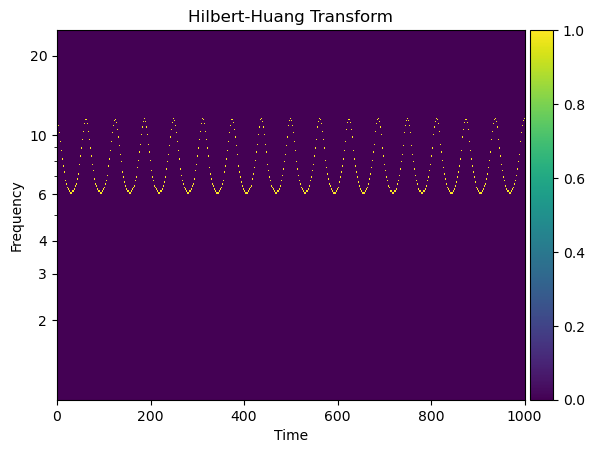

In [630]:
f2, hht2 = emd.spectra.hilberthuang(IFgt, IAgt, freq_edges, mode='amplitude', sum_time=False)
emd.plotting.plot_hilberthuang(hht2, time_centres, f2,
                               cmap='viridis', time_lims = (0,srate), freq_lims=(1,30), log_y=True)

In [5]:
#THE FIRST 30 for increasing noise
selected_imfs_trials = []

pmsis_avg = np.zeros((len(noise_bins), len(method_names), 100))
pmsis_per_bin = np.zeros((100, len(noise_bins)))
# 
for row in range(30):
    # initialise a new set of 20 lfps
    generated_lfps_noise = []
    # this list will contain 20 lists of length n_methods.
    # because this represents the pmsi's of the n methods on the
    pmsis_trials = []
    # create a set of 20 signals, with noise ranging from 0.1 to 2.
    for sigma in noise_bins:
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        generated_lfps_noise.append(lfp)
    # compute the pmsi of the methods on the 20 signals
    for count, gen_lfp in enumerate(generated_lfps_noise):
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(gen_lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_avg[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")


 i = 29 , [[0.005994018242900719, 0.044773493635993034, 0.04835332104778446, 0.005957267056392928, 0.2872476676096183], [0.0061141949348971075, 0.27308609870523515, 0.03689725717675773, 0.006112300009902875, 0.2664229541655911], [0.00556458048847778, 0.28727434519657974, 0.03735465631304223, 0.005675302131947699, 0.2503010727616662], [0.005006001163982803, 0.2921889695502213, 0.03737392082222887, 0.005009041346739784, 0.23103537430618135], [0.004893132239944523, 0.2698437809520361, 0.037866445202882876, 0.005302423120416274, 0.19247532418640667], [0.005321017948318156, 0.26474062862811143, 0.03815564191767931, 0.004961008031210678, 0.21163266994874996], [0.0054091094956721635, 0.2648715704279548, 0.038302138701390036, 0.005379138454312448, 0.2266221047575259], [0.006005667608391089, 0.26612314639975865, 0.03877027942443343, 0.006162747455968709, 0.19522159875312664], [0.006608145492983019, 0.28232411047060724, 0.03919843513059032, 0.006643698590903636, 0.21528149005603137], [0.00726645

In [13]:
#THE 30-70 for increasing noise
for row in range(30, 70):
    generated_lfps_noise = []
    pmsis_trials = []
    for sigma in noise_bins:
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        generated_lfps_noise.append(lfp)
    for count, gen_lfp in enumerate(generated_lfps_noise):
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(gen_lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_avg[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")


 i = 69 , [[0.006027831719919994, 0.09612433301113153, 0.043560421607207564, 0.005990237068617789, 0.2754535917016971], [0.005989656168879714, 0.2675931352451626, 0.03712804590867925, 0.006018654065376789, 0.2553108636301195], [0.005711685712797795, 0.24676335869371616, 0.03704748644675079, 0.005715363061635961, 0.26176969838239805], [0.005471390185736611, 0.2936005088640807, 0.037566094682174186, 0.005268817729059686, 0.22201845478001764], [0.005021542888078914, 0.2709726852582948, 0.03817449373554205, 0.005213435848515612, 0.21614178871873577], [0.005587708225471016, 0.27115678150911343, 0.038240410984200945, 0.0053641943857119494, 0.23468364426940835], [0.006253560981279418, 0.28166366916585567, 0.038311079778009294, 0.006383687121979822, 0.22353823695728506], [0.006299747835008361, 0.246740428141658, 0.03899672197396336, 0.005929941747612154, 0.21258900280345758], [0.006388089043897876, 0.2390205213133016, 0.03954636664848106, 0.006561305086916824, 0.20432343797562721], [0.00623877

In [44]:
#THE 70-100 for increasing noise
for row in range(70, 100):
    pmsis_trials = []
    for sigma in noise_bins:
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_avg[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")


 i = 99 , [[0.005999061739799942, 0.05272990087501579, 0.04778926234091059, 0.005963503630977506, 0.2898810420225227], [0.006048733224600472, 0.2544333562756703, 0.03681628591285996, 0.005944754066552221, 0.26084139947109825], [0.005557862621020801, 0.25732455063121157, 0.03718627257318541, 0.005607834737237157, 0.2575627286498332], [0.005820768921749292, 0.2869467625168519, 0.03766014392645768, 0.0056544315921725815, 0.22290616892427795], [0.005247328594898458, 0.2969442223472666, 0.03788551872799294, 0.005576243888301173, 0.22497203210397437], [0.005750235670744752, 0.26724168501228823, 0.03780485328522481, 0.005629939022258133, 0.1954499412820321], [0.005518703948252487, 0.265862563811673, 0.038036571029507416, 0.005687536423609689, 0.2166107844640165], [0.00682245406755393, 0.26595028890618005, 0.03915582670607076, 0.006727813605354481, 0.20573503988104697], [0.0062962432764449, 0.2566202043563619, 0.03890757066998088, 0.006618772793342815, 0.20033530264716734], [0.0069878188057662

In [146]:
# means and stds on signals with increasing noise
pmsi_mean_noise = np.nanmean(pmsis_avg, axis=2)
pmsi_std_noise = np.nanstd(pmsis_avg, axis=2)
# without the masked emd IF
test_mean = np.delete(pmsi_mean_noise, 1, axis=1)
test_std = np.delete(pmsi_std_noise, 1, axis=1)

test_mean2 = np.delete(test_mean, 3, axis=1)
test_std2 = np.delete(test_std, 3, axis=1)
test_mean2 = np.delete(test_mean2, -2, axis=1)
test_std2 = np.delete(test_std2, -2, axis=1)


# method_names2 = ['Iterated mask ZC EMD', 'Masked ZC EMD', 'Iterated mask IF EMD', 'Ensemble EMD']
method_names3 = ['Iterated mask ZC EMD', 'Iterated mask IF EMD']
allnames = [method_names, method_names3]

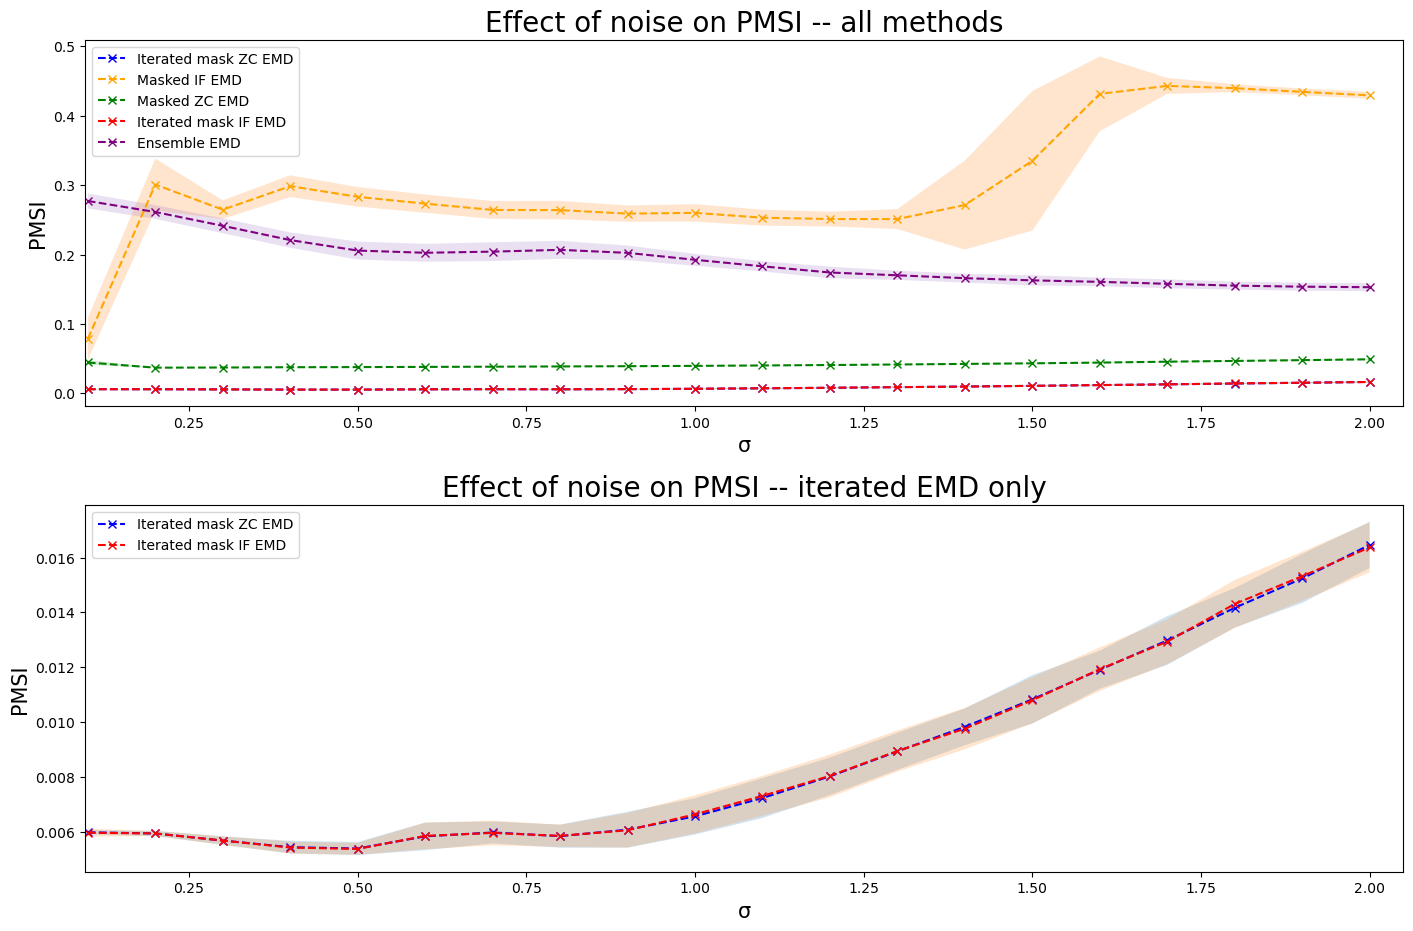

In [147]:
# increasing noise PMSI plot
fig1, axs1 = plt.subplots(2, 1, figsize=(15,10))
fig1.tight_layout(pad=5)
for method, errors, method_name, color in zip(pmsi_mean_noise.T, pmsi_std_noise.T, method_names, method_colors):
    axs1[0].plot(noise_bins, method, '--x', label = method_name, color=method_dict[method_name])
    axs1[0].fill_between(noise_bins, method-errors, method+errors, alpha=0.2)
    axs1[0].set_ylabel('PMSI', size=15)
    axs1[0].set_xlabel('\u03C3', size=15)
    axs1[0].set_title('Effect of noise on PMSI -- all methods', size = 20)
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    axs1[0].set_xlim(0.096,2.05)
    axs1[0].legend()
for method, errors, method_name in zip(test_mean2.T, test_std2.T, method_names3):
    axs1[1].plot(noise_bins, method, '--x', label = method_name, color=method_dict[method_name])
    axs1[1].fill_between(noise_bins, method-errors, method+errors, alpha=0.2)
    axs1[1].set_ylabel('PMSI', size=15)
    axs1[1].set_xlabel('\u03C3', size=15)
    axs1[1].set_title('Effect of noise on PMSI -- iterated EMD only', size = 20)
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    axs1[1].set_xlim(0.096,2.05)
    axs1[1].legend()
plt.show()

In [83]:
#THE FIRST 50 for increasing fd
selected_imfs_trials = []

fd_bins = np.linspace(0,20, 21)
pmsis_fd = np.zeros((len(fd_bins), len(method_names), 100))
# 
for row in range(50):
    # initialise a new set of 20 lfps
    generated_lfps_noise = []
    # this list will contain 20 lists of length n_methods.
    # because this represents the pmsi's of the n methods on the
    pmsis_trials = []
    # create a set of 21 signals, with an iterated sine function ranging from zero to 21 iterated sine functions
    for n_sin in fd_bins:
        if int(n_sin) == 0:
            theta_component = theta_pure
        else:
            theta_component = iterated_sine(theta_pure, int(n_sin))
        Af_a_gamma = (0.2*(theta_component+1)+nonmodulatedamplitude*0.1)
        gamma_component = Af_a_gamma * gamma_pure
        lfp = gamma_component + theta_component  
        gauss = np.random.randn(1,len(lfp)) #gaussian noise, sigma =1
        lfp= np.add(lfp,gauss[0])
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_fd[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")

 i = 49 , [[0.006574342859067631, 0.23874068696696618, 0.04072353476673775, 0.006717043212779831, 0.20767835286581185], [0.006056880377678947, 0.2815727365625747, 0.040721072090781504, 0.006261705959702386, 0.18681010392332958], [0.006268632255375403, 0.23988400861927459, 0.03947042020325554, 0.00616112617710213, 0.19523495837241384], [0.0066997034271397, 0.26974078062137113, 0.040415512299569495, 0.007082690487797478, 0.1954606386461182], [0.007845071772393396, 0.251785051405253, 0.039469079265827885, 0.006811384212865439, 0.22245546093226498], [0.006031678858212785, 0.24576416465633624, 0.03954768979497016, 0.006857445952097654, 0.18331928625044858], [0.006083724014034989, 0.25014817061526234, 0.039355451412798954, 0.006418032522921377, 0.19643765054355541], [0.006690791435243858, 0.2918284607774272, 0.03951648182791945, 0.006298554421646689, 0.19100750116749676], [0.007932998458846301, 0.2596228711152588, 0.04022460030975859, 0.007369747861038393, 0.19621169377275707], [0.0070032070

In [153]:
# The last 50 for increasing fd
for row in range(50,100):
    # this list will contain 20 lists of length n_methods.
    # because this represents the pmsi's of the n methods on the
    pmsis_trials = []
    # create a set of 21 signals, with an iterated sine function ranging from zero to 21 iterated sine functions
    for n_sin in fd_bins:
        if int(n_sin) == 0:
            theta_component = theta_pure
        else:
            theta_component = iterated_sine(theta_pure, int(n_sin))
        Af_a_gamma = (0.2*(theta_component+1)+nonmodulatedamplitude*0.1)
        gamma_component = Af_a_gamma * gamma_pure
        lfp = gamma_component + theta_component  
        gauss = np.random.randn(1,len(lfp)) #gaussian noise, sigma =1
        lfp= np.add(lfp,gauss[0])
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_fd[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")

 i = 99 , [[0.007232992007823252, 0.25953950237708945, 0.040621987867932405, 0.007312714106489687, 0.20550332257337922], [0.006723496853700881, 0.26839163155315576, 0.040784412793390734, 0.006730391030317396, 0.2130833491672032], [0.006794532131799955, 0.2460581760040498, 0.03966477767969628, 0.006643263826645587, 0.20380891502841075], [0.006754342347561447, 0.23331045729908628, 0.04053693432022909, 0.00654132853374914, 0.19970453393687634], [0.006510445521060677, 0.2594185661176044, 0.03940538567739894, 0.007292541010599456, 0.2008468321380512], [0.007490873342689182, 0.27792805104938684, 0.04001054464199989, 0.007087539445079657, 0.2043720417767971], [0.007156467968815536, 0.2604742769125427, 0.039439506799148316, 0.007325235627109575, 0.18028832723609708], [0.005575734163839302, 0.2666075593888682, 0.039569923114602557, 0.005689436214346268, 0.19109907831070136], [0.007749597550360779, 0.24911270188419524, 0.040039235477620685, 0.00770938896822863, 0.18537146085757494], [0.005600074

In [154]:
# mean pmsi and std of the methods on increasing fd signals
pmsi_mean_fd = np.nanmean(pmsis_fd, axis=2)
pmsi_std_fd = np.nanstd(pmsis_fd, axis=2)
test_mean_fd = np.delete(pmsi_mean_fd, 1, axis=1)
test_std_fd = np.delete(pmsi_std_fd, 1, axis=1)

test_mean_fd = np.delete(test_mean_fd, 3, axis=1)
test_std_fd = np.delete(test_std_fd, 3, axis=1)

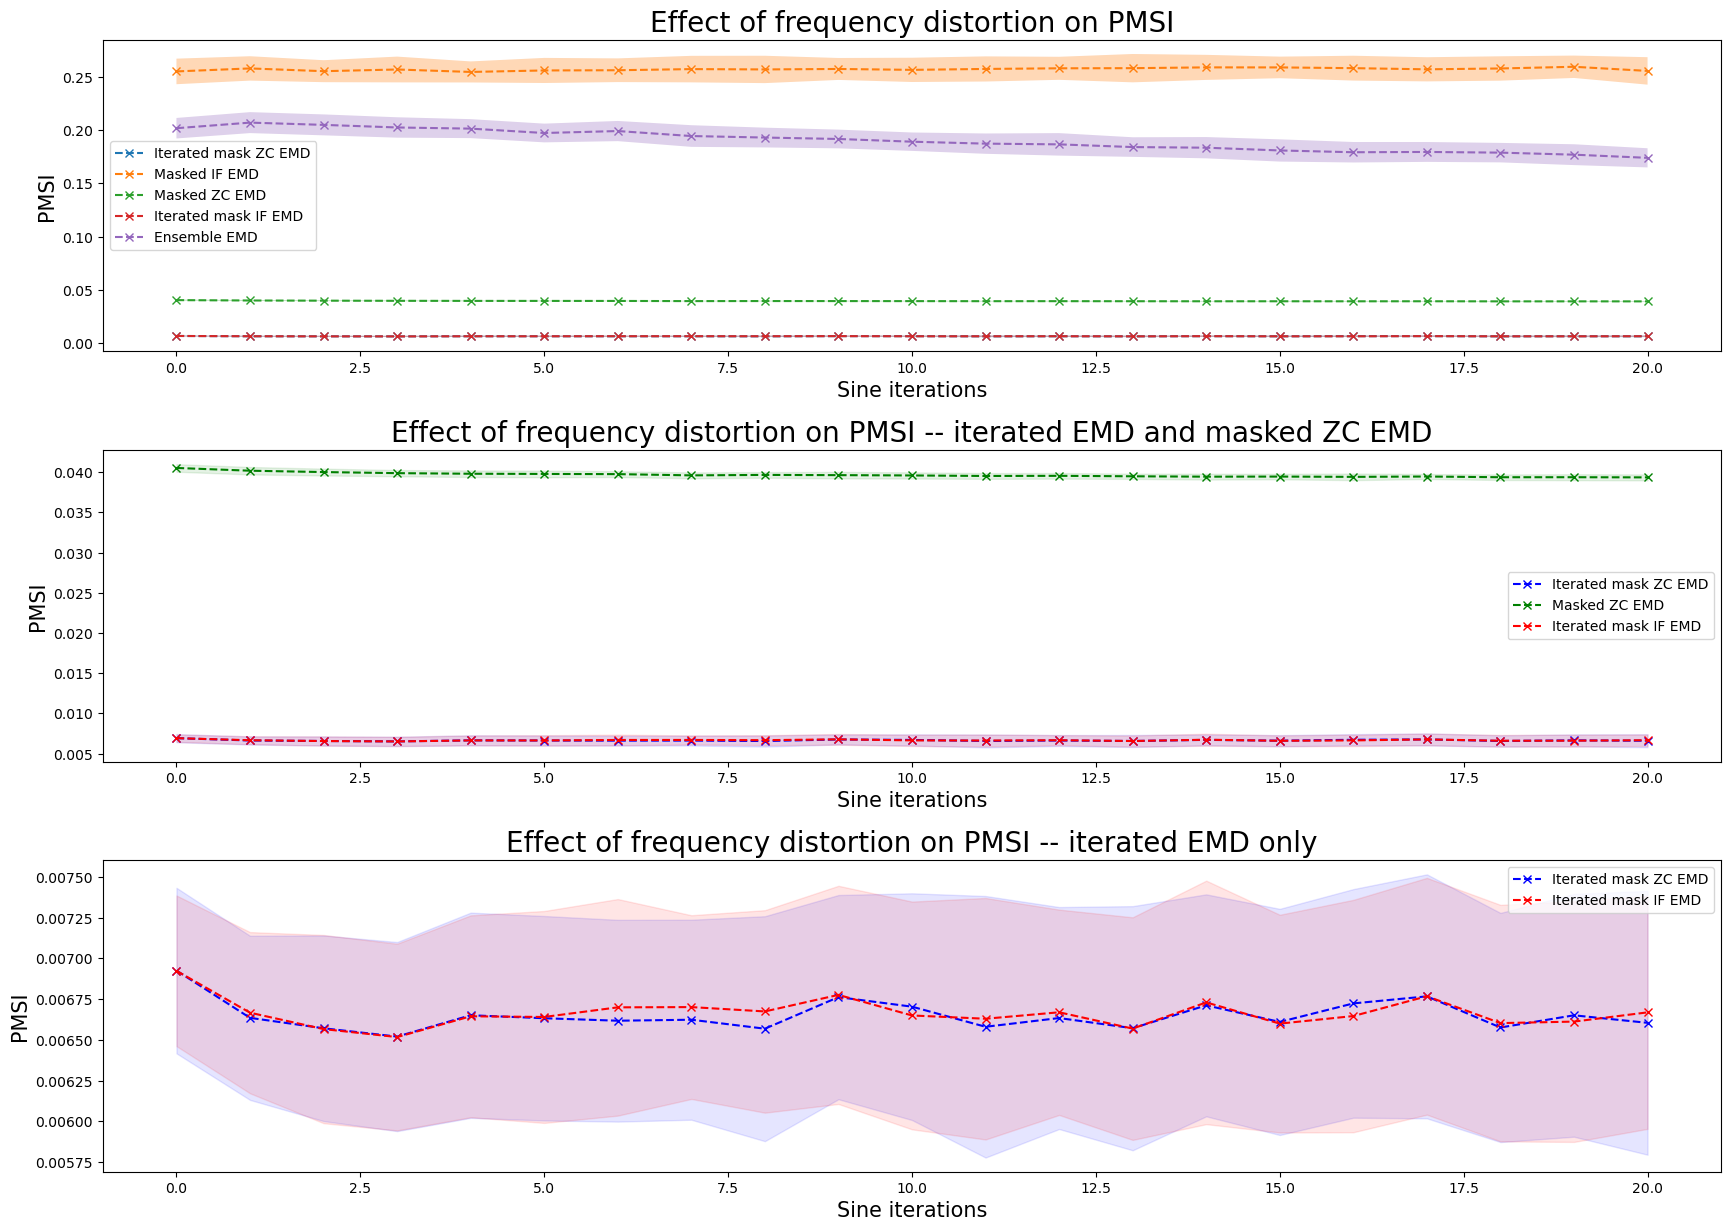

In [170]:
# increasing nonsinusoidality plot
fig2, axs2 = plt.subplots(3, 1, figsize=(18,13))
fig2.tight_layout(pad=5)
for method, errors, method_name in zip(pmsi_mean_fd.T, pmsi_std_fd.T, method_names):
    axs2[0].plot(fd_bins, method, '--x', label = method_name)
    axs2[0].fill_between(fd_bins, method-errors, method+errors, alpha=0.3)
    axs2[0].set_ylabel('PMSI', size=15)
    axs2[0].set_xlabel('Sine iterations', size=15)
    axs2[0].set_title('Effect of frequency distortion on PMSI', size = 20)
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    # axs2.set_xlim(0.096,2.05)
    axs2[0].legend()
for method, errors, method_name in zip(test_mean_fd.T, test_std_fd.T, ['Iterated mask ZC EMD', 'Masked ZC EMD', 'Iterated mask IF EMD']):
    axs2[1].plot(fd_bins, method, '--x', label = method_name, color=method_dict[method_name])
    axs2[1].fill_between(fd_bins, method-errors, method+errors, color=method_dict[method_name], alpha=0.1)
    axs2[1].set_ylabel('PMSI', size=15)
    axs2[1].set_xlabel('Sine iterations', size=15)
    axs2[1].set_title('Effect of frequency distortion on PMSI -- iterated EMD and masked ZC EMD', size = 20)
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    axs2[1].legend()
for method, errors, method_name in zip(test_mean_fd[:,0:3:2].T, test_std_fd[:,0:3:2].T, method_names3):
    axs2[2].plot(fd_bins, method, '--x', label = method_name, color=method_dict[method_name])
    axs2[2].fill_between(fd_bins, method-errors, method+errors, color=method_dict[method_name], alpha=0.1)
    axs2[2].set_ylabel('PMSI', size=15)
    axs2[2].set_xlabel('Sine iterations', size=15)
    axs2[2].set_title('Effect of frequency distortion on PMSI -- iterated EMD only', size = 20)
    # axs1[i].set_xticks(size=10)
    # axs1[i].set_yticks(size=10)
    axs2[2].legend()
plt.show()

In [30]:
# run EMD on signals with some amount of noise
Tgenerated_lfps_noise = []
sigma_test = [0.1,0.2,1.4,1.5]
for sigma in sigma_test:
    Tlfp = fixed_gamma_noise + fixed_theta_noise  
    Tgauss = sigma * np.random.randn(1,len(Tlfp)) #gaussian noise
    Tlfp= np.add(Tlfp,Tgauss[0])
    Tgenerated_lfps_noise.append(Tlfp)
imm_all, selim_all_all, sf_all_all, ti_all_all, sh_all_all, pmsis_all_all = [], [], [], [], [], []
for tlfp in Tgenerated_lfps_noise:
    imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(tlfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
    imm_all.append(imfs_methods)
    selim_all_all.append(selected_imfs_all)
    sf_all_all.append(selected_freqs_all)
    ti_all_all.append(theta_indices)
    sh_all_all.append(selected_hhts)
    pmsis_all_all.append(pmsis_all)

In [43]:
for sigma, freqs, indices, pmsis in zip(sigma_test, sf_all_all, ti_all_all, pmsis_all_all):
    print("\u03C3 = {}: ".format(sigma), 'Freqs of imfs: ', freqs, 'Index imfs: ',indices, 'PMSIs: ', np.array(pmsis))

σ = 0.1:  Freqs of imfs:  [[7.95], [7.95], [7.95], [7.95], [7.95]] Index imfs:  [[3], [4], [5], [3], [4]] PMSIs:  [0.00598506 0.08905329 0.04231804 0.00596325 0.28520105]
σ = 0.2:  Freqs of imfs:  [[7.95], [7.95], [7.95], [7.95], [7.95]] Index imfs:  [[3], [4], [5], [3], [4]] PMSIs:  [0.00593329 0.26636301 0.03682611 0.00593118 0.26461536]
σ = 1.4:  Freqs of imfs:  [[8.25], [7.95], [7.95], [8.25], [8.05]] Index imfs:  [[3], [5], [5], [3], [4]] PMSIs:  [0.01087474 0.23171842 0.041345   0.01077505 0.16520992]
σ = 1.5:  Freqs of imfs:  [[8.25], [7.75], [7.95], [7.95], [7.95]] Index imfs:  [[3], [5], [5], [3], [4]] PMSIs:  [0.01196602 0.42348344 0.04218006 0.01043173 0.16588715]


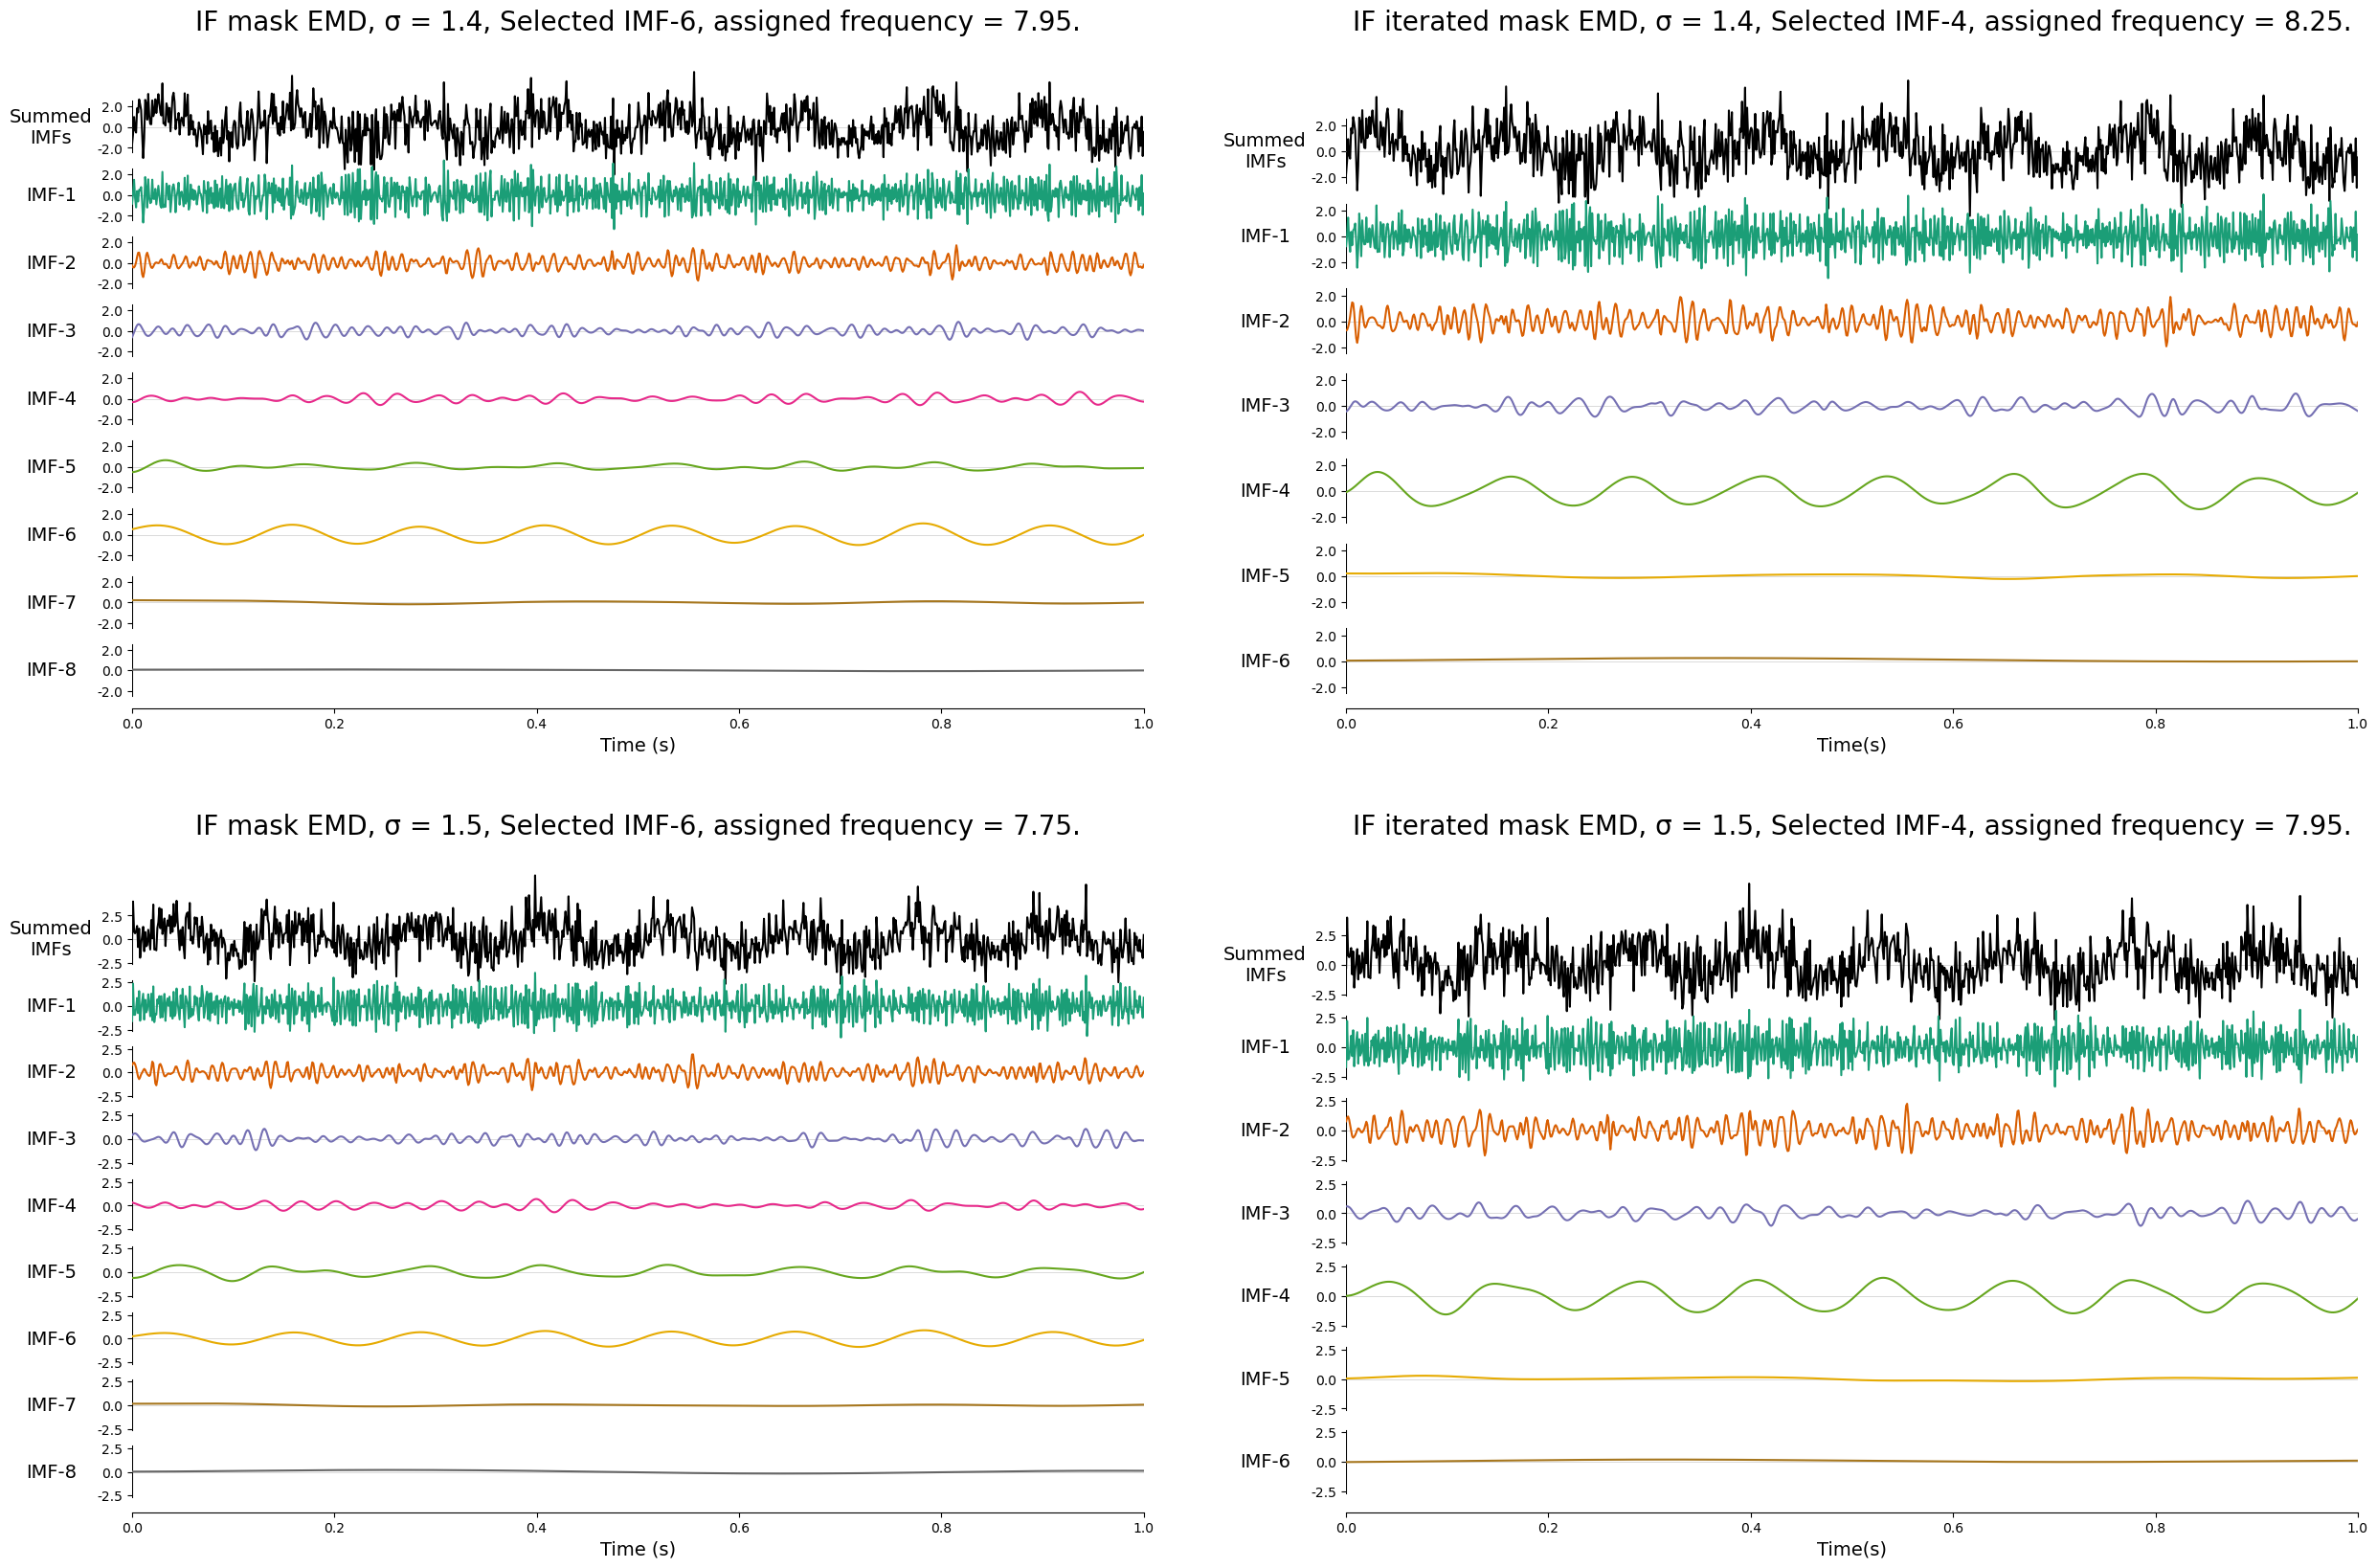

In [169]:
fig11, axs11 = plt.subplots(2,2, figsize=(30,20))
for row, methods_imfs, sigma, sel_freqs, indices in zip(range(len(imm_all[2:])), imm_all[2:], sigma_test[2:], sf_all_all[2:], ti_all_all[2:]):
    emd.plotting.plot_imfs(methods_imfs[1][:srate], xlabel='Time (s)', fig = fig11, ax = axs11[row,0], sample_rate = srate)
    emd.plotting.plot_imfs(methods_imfs[3][:srate], xlabel='Time(s)',fig = fig11, ax = axs11[row,1], sample_rate = srate)
    axs11[row,0].set_title('IF mask EMD, \u03C3 = {}, Selected IMF-{}, assigned frequency = {}.'.format(sigma, indices[1][0]+1, sel_freqs[1][0]), size = 20)
    axs11[row,1].set_title('IF iterated mask EMD, \u03C3 = {}, Selected IMF-{}, assigned frequency = {}.'.format(sigma, indices[3][0]+1, sel_freqs[3][0]), size = 20)

In [775]:
len(noise_bins)

20

In [71]:
selected_imfs_trials = []

pmsis_avg = np.zeros((len(noise_bins), len(method_names), 100))
pmsis_per_bin = np.zeros((100, len(noise_bins)))
for row in range(100):
    generated_lfps_noise = []
    pmsis_trials = []
    for sigma in noise_bins:
        lfp = fixed_gamma_noise + fixed_theta_noise  
        gauss = sigma * np.random.randn(1,len(lfp)) #gaussian noise
        lfp= np.add(lfp,gauss[0])
        generated_lfps_noise.append(lfp)
    for count, gen_lfp in enumerate(generated_lfps_noise):
        imfs_methods, selected_imfs_all, selected_freqs_all, theta_indices, selected_hhts, pmsis_all = gensignal_analysis(gen_lfp, srate, maskmethods_gen, ensemblemethods_gen, freq_edges, 8, pmsi_only = False)
        pmsis_trials.append(pmsis_all)
    pmsis_avg[:,:,row] = np.array(pmsis_trials)
    print('\r i = {} , {}'.format(row, (pmsis_trials) ), end="")


 i = 99 , [[0.03791683333105916, 0.22586787089380395, 0.035377093641605115, 0.006113145181873638, 0.2887003963474731], [0.00564129674783869, 0.2921301339796841, 0.03845998622769404, 0.005631079741302436, 0.25851211007201985], [0.005328375236996601, 0.2830552883109861, 0.03913787575757245, 0.005257195554452283, 0.2547538805015606], [0.0050998217627606516, 0.2711935610081961, 0.036316332711710225, 0.0049092924620777086, 0.24112249029238925], [0.005029813939503603, 0.26529284917346485, 0.12691028482025601, 0.004746781565670968, 0.21927486272912283], [0.004374446154328639, 0.27184855326373863, 0.03750443449212981, 0.004592694984044397, 0.20347308171347106], [0.004576967691634182, 0.25214044371198846, 0.03880039601062607, 0.061774320206622796, 0.16707905123312067], [0.006086306041616781, 0.24685826972905478, 0.039798464130753296, 0.00533486751211598, 0.18824026603631894], [0.006928908942629125, 0.23583870435246862, 0.04058689847455369, 0.006120525755002448, 0.20865836865405482], [0.00612856

In [82]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

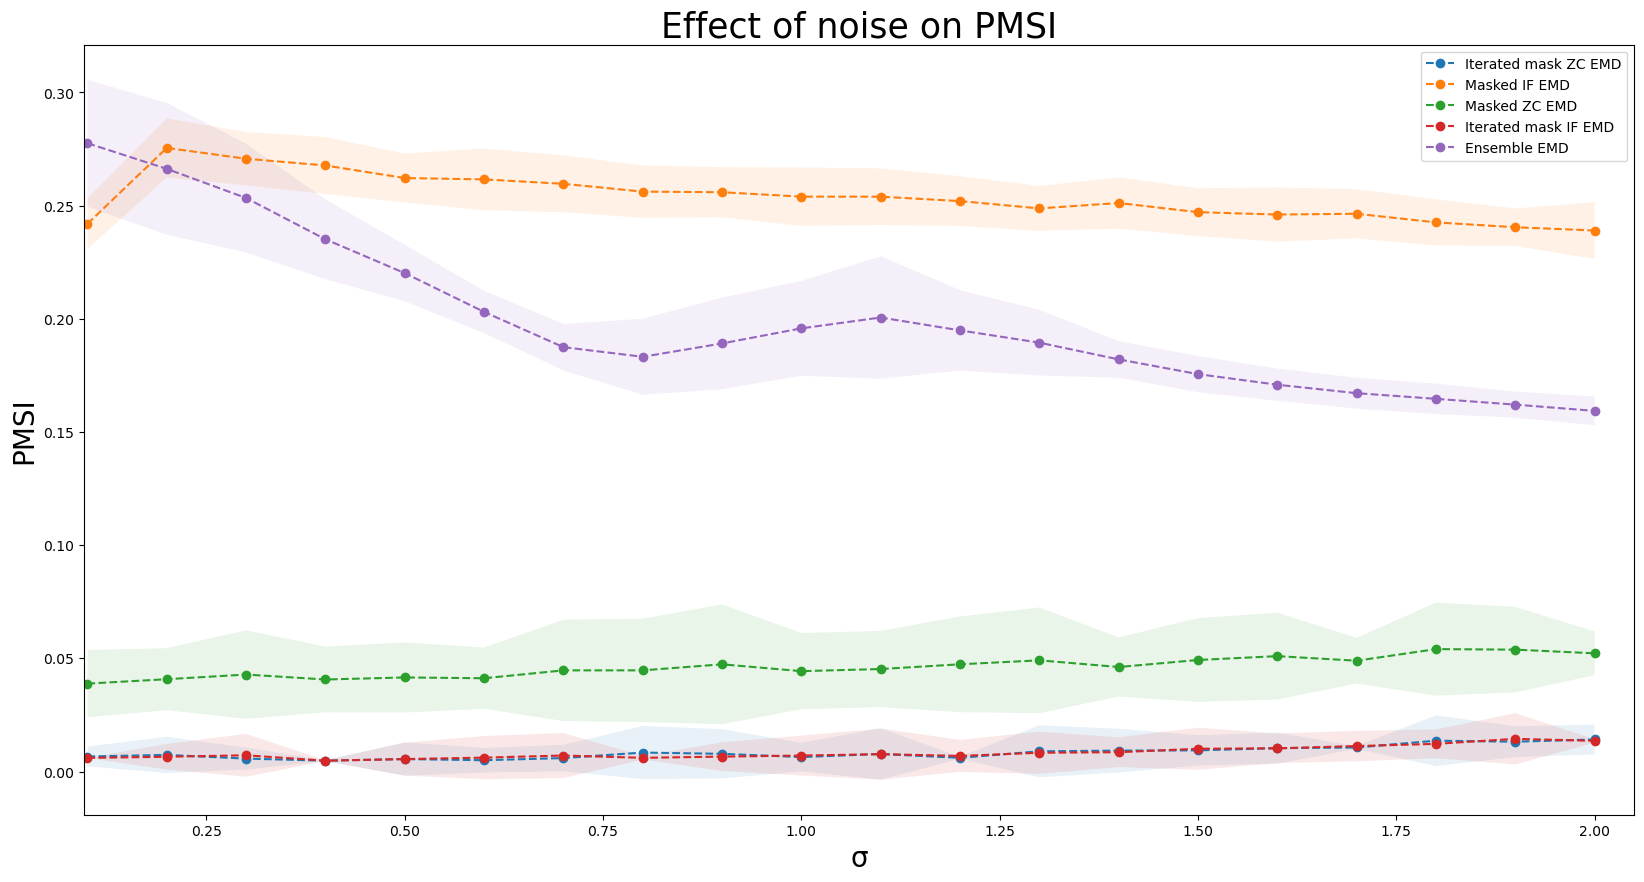

In [132]:
fig1, axs1 = plt.subplots(1, 1, figsize=(20,10))
for method, errors, method_name in zip(pmsis_means.T, pmsis_stds.T, method_names):
    plt.plot(noise_bins, method, '--o', label = method_name)
    plt.fill_between(noise_bins, method-errors, method+errors, alpha=0.1)
plt.ylabel('PMSI', size=20)
plt.xlabel('\u03C3', size=20)
plt.title('Effect of noise on PMSI', size = 25)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlim(0.096,2.05)
plt.legend()
plt.show()